<a href="https://colab.research.google.com/github/shshinc/abalone_age_predict/blob/main/Abalone_age_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import lightgbm
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
#파일을 읽고 고유번호 id 값 처리
#분석할 때에는 데이터의 위치를 필요로 하지 않기 때문에 제거해준다.
file_train = '/train2.csv'
file_test =  '/test2.csv'
train_data = pd.read_csv(file_train)
test_data = pd.read_csv(file_test)
train_data = train_data.drop('id', axis = 1)
train_data = train_data.drop(['Unnamed: 0'], axis = 1)
test_data = test_data.drop('id', axis = 1)
test_data = test_data.drop(['Unnamed: 0'], axis = 1)
print(train_data.head())
print(test_data.head())


  Gender  Lenght  Diameter  Height  Whole Weight  Shucked Weight  \
0      M   0.570     0.480   0.180        0.9395          0.3990   
1      M   0.560     0.425   0.135        0.9415          0.5090   
2      F   0.655     0.510   0.150        1.0430          0.4795   
3      I   0.310     0.225   0.050        0.1445          0.0675   
4      M   0.310     0.225   0.075        0.1295          0.0455   

   Viscra Weight  Shell Weight  Target  
0         0.2000        0.2950      14  
1         0.2015        0.1975       9  
2         0.2230        0.3050       9  
3         0.0385        0.0450       6  
4         0.0335        0.0440       9  
  Gender  Lenght  Diameter  Height  Whole Weight  Shucked Weight  \
0      F   0.435     0.350   0.125        0.4590          0.1970   
1      M   0.525     0.395   0.165        0.7820          0.2850   
2      M   0.465     0.360   0.080        0.4880          0.1910   
3      I   0.380     0.300   0.090        0.2770          0.1655   
4    

# EDA

In [ ]:
#결측치 확인을 위한 코드
# 결측치란 값이 누락된 데이터를 말하는데 정확한 분석을 위해서는 적절히 처리해주어야한다.
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train_data)

결측치가 존재하지 않습니다


In [ ]:
train_data.describe()

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
count,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000
mean,0.522924,0.407036,0.139476,0.831996,0.358900,0.181458,0.239849,9.921029
std,0.121090,0.100372,0.039082,0.502113,0.225445,0.112655,0.142285,3.236664
min,0.110000,0.090000,0.030000,0.008000,0.002500,0.002000,0.003000,3.000000
25%,0.445000,0.345000,0.112500,0.440250,0.180750,0.092500,0.127500,8.000000
50%,0.540000,0.420000,0.140000,0.777500,0.326500,0.168500,0.230500,10.000000
75%,0.615000,0.480000,0.165000,1.167000,0.503500,0.259000,0.330000,11.000000
max,0.780000,0.630000,0.250000,2.779500,1.488000,0.760000,1.005000,29.000000


In [ ]:
train_data.dtypes

Gender             object
Lenght            float64
Diameter          float64
Height            float64
Whole Weight      float64
Shucked Weight    float64
Viscra Weight     float64
Shell Weight      float64
Target              int64
dtype: object

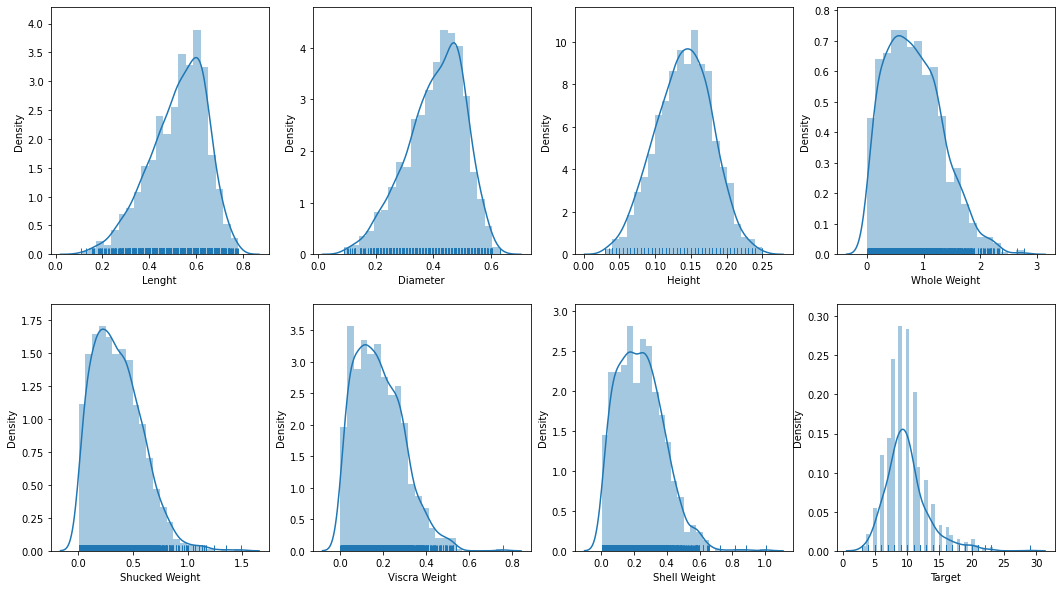

In [ ]:
# 컬럼별 Data 분포 히스토그램
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (18, 10))

num = 0
ax = ax.flatten()

for col in list(train_data.columns[1:]):
    sns.distplot(train_data[col], ax = ax[num], kde = True, rug = True) # kde True는 확률 밀도 곡선이 나오고, rug는 하부에 밀도 분포표시
    num += 1    
    
plt.show()

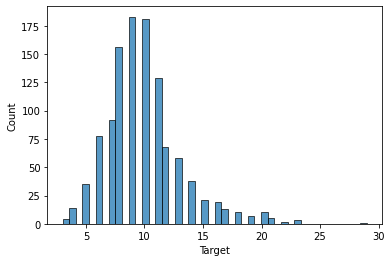

In [ ]:
#taget 분포 히스토그램
sns.histplot(train_data['Target'])

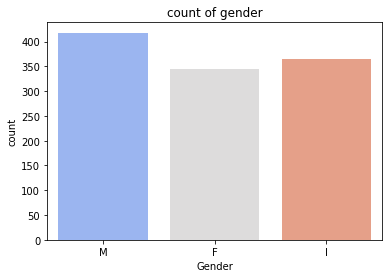

In [ ]:
#gender 분포 히스토그램
sns.countplot(x = 'Gender', data = train_data, palette="coolwarm")
plt.title('count of gender')
plt.show()

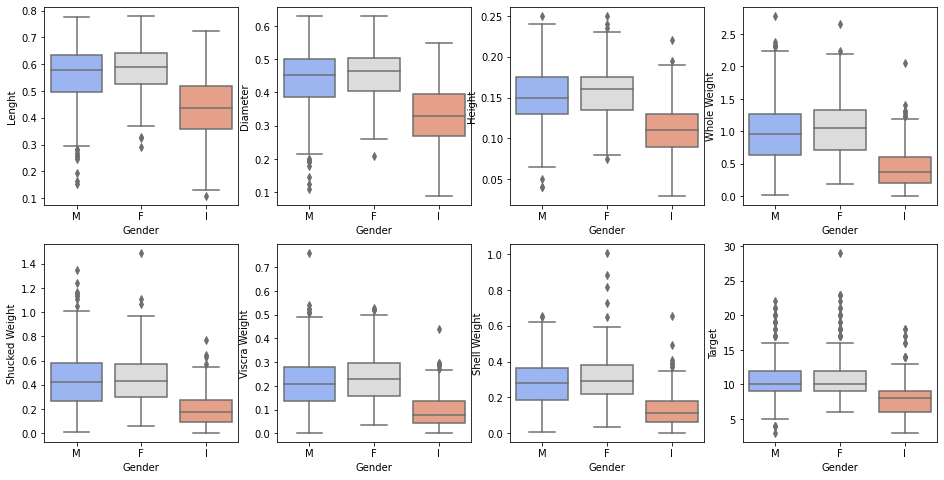

In [ ]:
fig = plt.figure(figsize=(16,8))

for i,col in enumerate(train_data.columns[1:]):
    fig.add_subplot(2,4,i+1)
    sns.boxplot(x="Gender", y=col, data=train_data, palette="coolwarm")

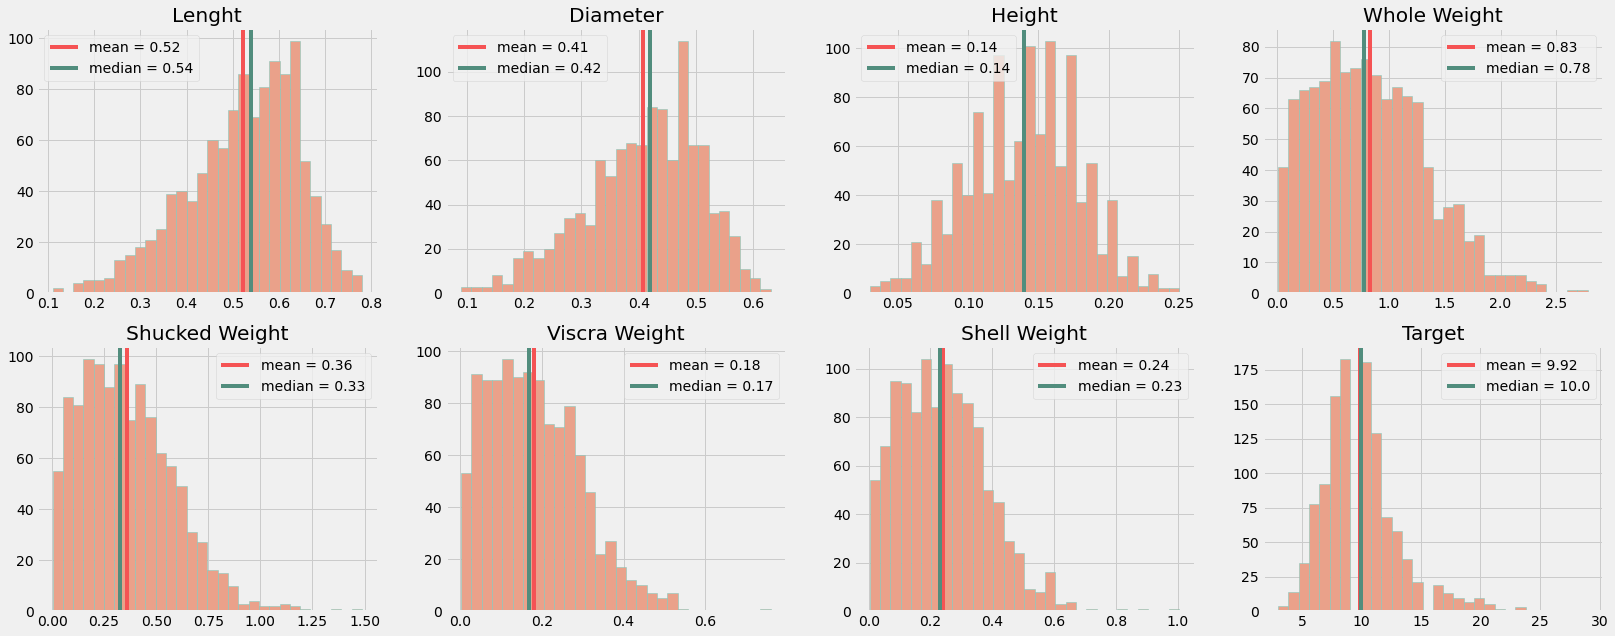

In [ ]:
# 수치형 데이터 통계치 그래프
data_description = train_data.describe()
interest_coloumns = train_data.columns[1:]
plt.style.use('fivethirtyeight')
fig, ax =plt.subplots(2, 4, figsize = (25, 10))
column_idx = 0
for i in range(2):
    for j in range(4):
        ax[i][j].hist(train_data[interest_coloumns[column_idx]], bins=30, color='#eaa18a', edgecolor='#7bcabf')
        ax[i][j].set_title(interest_coloumns[column_idx])
        ax[i][j].axvline(data_description[interest_coloumns[column_idx]]['mean'], c='#f55354', label = f"mean = {round(data_description[interest_coloumns[column_idx]]['mean'], 2)}")
        ax[i][j].axvline(data_description[interest_coloumns[column_idx]]['50%'], c='#518d7d', label = f"median = {round(data_description[interest_coloumns[column_idx]]['50%'], 2)}")
        ax[i][j].legend()
        column_idx += 1

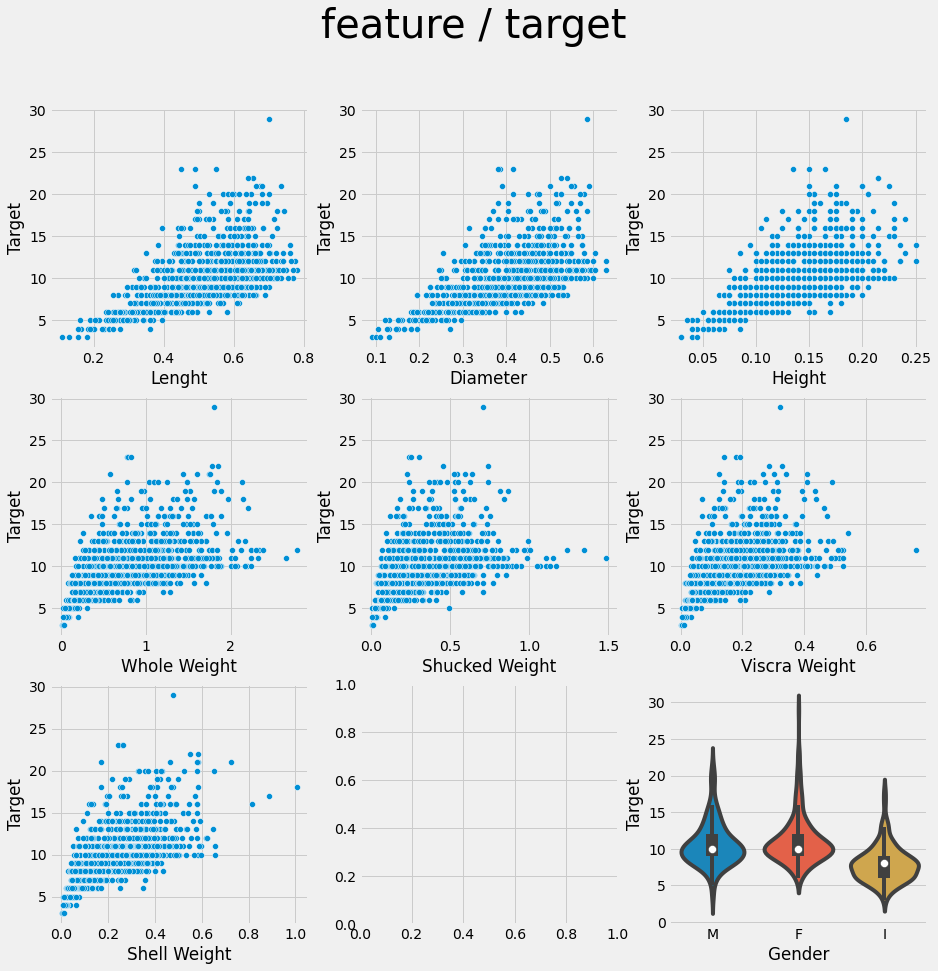

In [ ]:
fig, ax = plt.subplots(3, 3, figsize = (14, 14))

plt.suptitle("feature / target", fontsize=40)

feature = ["Lenght", "Diameter", "Height", "Whole Weight", "Shucked Weight", "Viscra Weight", "Shell Weight", "Gender"]

xvalue = 0
yvalue = 0

for xstr in feature:
    if xstr == "Gender":
        sns.violinplot(x = xstr, y = 'Target', data = train_data)
    else:
        sns.scatterplot(x = xstr, y = 'Target', data = train_data, ax = ax[yvalue][xvalue])
        
    if xvalue == 2:
        xvalue = 0
        yvalue += 1
    else:
        xvalue += 1

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
Lenght,1.000000,0.987336,0.905323,0.926032,0.895539,0.902617,0.897628,0.544288
Diameter,0.987336,1.000000,0.912596,0.928018,0.891400,0.901182,0.907122,0.569380
Height,0.905323,0.912596,1.000000,0.897565,0.840838,0.868035,0.902457,0.606440
Whole Weight,0.926032,0.928018,0.897565,1.000000,0.967998,0.966080,0.952435,0.536748
Shucked Weight,0.895539,0.891400,0.840838,0.967998,1.000000,0.931633,0.872618,0.418847
Viscra Weight,0.902617,0.901182,0.868035,0.966080,0.931633,1.000000,0.903189,0.494249
Shell Weight,0.897628,0.907122,0.902457,0.952435,0.872618,0.903189,1.000000,0.624020
Target,0.544288,0.569380,0.606440,0.536748,0.418847,0.494249,0.624020,1.000000


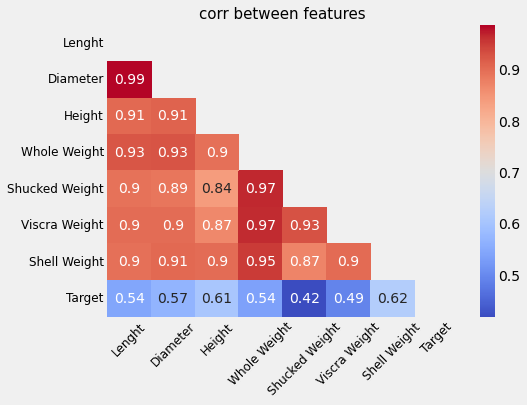

In [ ]:
plot_cols_list = train_data.columns[1:]
def corr_heat(df):
    plt.figure(figsize=(7,5))

    corr_df = df.corr()
    display(corr_df)

    mask = np.zeros_like(corr_df)
    mask[np.triu_indices_from(mask)] = 1
    heat_map = sns.heatmap(corr_df, annot=True, mask = mask, cmap='coolwarm')
    heat_map.set_xticklabels(heat_map.get_xticklabels(), fontsize=12, rotation=45)
    heat_map.set_yticklabels(heat_map.get_yticklabels(), fontsize=12)
    plt.title('corr between features', fontsize=15)
    plt.show()
    
corr_heat(train_data[plot_cols_list])

연속형 변수끼리는 모두 높은 상관관계를 보인다. 값들이 비슷한 양상을 보일것 같기에 수치형 학습보다는 트리기반 모델이 더 어울릴 것이라고 예상했다.

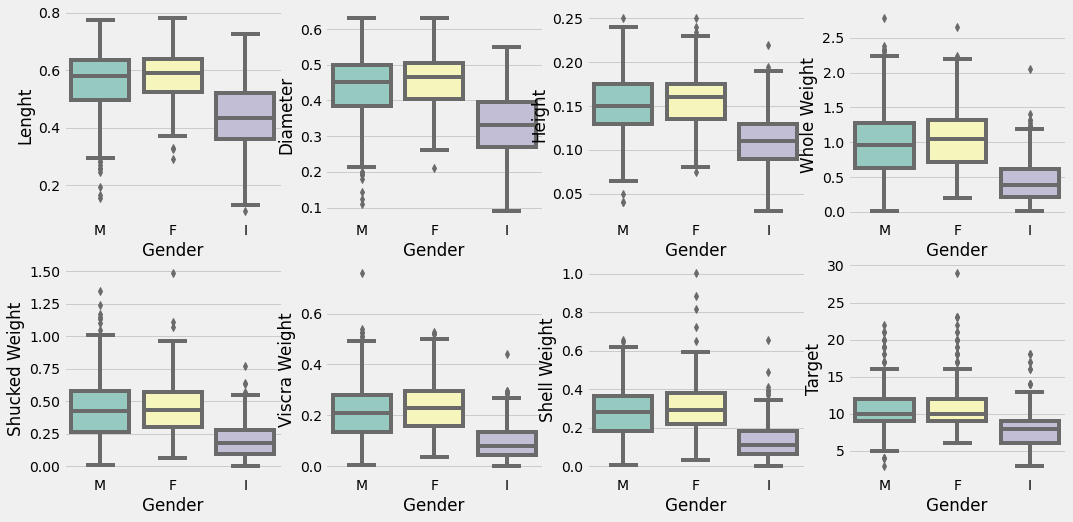

In [ ]:
fig = plt.figure(figsize=(16,8))

for i,col in enumerate(plot_cols_list):
    fig.add_subplot(2,4,i+1)
    sns.boxplot(x="Gender", y=col, data=train_data, palette="Set3")

유일한 category변수인 성별 변수이다. I라는 성별이 모든 변수에서 전체적으로 값이 낮은 것으로 보여지기에 학습시 I를 따로 모델을 만들어야 할 수도 있다고 예측했다.

## **Feature 처리과정**

이상치 제거.
1. 전체 무게 < 전복무게 + 껍질의 무게인 경우 삭제
2. train_data에서 target값이 혼자서 너무 높거나 너무 낮은 값은 이상치라고 판단하고 삭제
3. 전복의 무게가 전복의 내장 무게보다 작은 경우 삭제
4. 길이보다 지름이 더 큰 경우 삭제

In [ ]:
train_data[train_data["Whole Weight"] < train_data["Shucked Weight"] + train_data["Shell Weight"]]



,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
39,I,0.455,0.330,0.100,0.3720,0.3580,0.0775,0.1100,8
76,I,0.230,0.165,0.060,0.0515,0.0190,0.0145,0.0360,4
367,I,0.275,0.205,0.070,0.1055,0.4950,0.0190,0.0315,5
837,I,0.475,0.365,0.100,0.1315,0.2025,0.0875,0.1230,7
840,I,0.380,0.275,0.095,0.1375,0.0860,0.0585,0.0605,7


In [ ]:
train_data[train_data["Target"]>20]

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
57,M,0.655,0.540,0.215,1.8440,0.7425,0.3270,0.585,22
272,M,0.675,0.555,0.200,1.4385,0.5450,0.2665,0.465,21
322,M,0.490,0.390,0.150,0.5730,0.2250,0.1240,0.170,21
505,F,0.700,0.585,0.185,1.8075,0.7055,0.3215,0.475,29
598,F,0.550,0.415,0.135,0.7750,0.3020,0.1790,0.260,23
614,F,0.640,0.525,0.215,1.7790,0.4535,0.2855,0.550,22
775,F,0.490,0.385,0.150,0.7865,0.2410,0.1400,0.240,23
886,F,0.665,0.500,0.175,1.7420,0.5950,0.3025,0.725,21
918,F,0.680,0.550,0.200,1.5960,0.5250,0.4075,0.585,21
925,M,0.735,0.590,0.225,1.7560,0.6370,0.3405,0.580,21


In [ ]:
train_data[train_data["Shucked Weight"] < train_data["Viscra Weight"]]

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
1023,M,0.415,0.315,0.125,0.388,0.068,0.09,0.125,12


In [ ]:
train_data[train_data["Lenght"] < train_data["Diameter"]]

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target


In [ ]:
train_data = train_data.drop([39, 76, 367, 837, 840, 505, 1023], axis = 0)

전체 무게에서 전복의 무게와 껍질의 무게를 빼게 되면 남는 값이 있는데, 이는 전복이 머금고 있는 물의 양이다.
전복이 머금고 있는 물의 양을 Shell Water라고 하고 Whole Weight에서 빼주어 학습시 물의 영향을 받지 않도록 하였고 Shell Water는 전복의 나이와 연관성이 없기에 다시 제거했다.

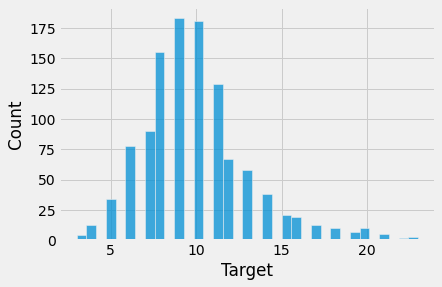

In [ ]:
train_data["Shell Water"] = train_data["Whole Weight"] - (train_data["Shucked Weight"] + train_data["Shell Weight"])
train_data["Whole Weight"] = train_data["Whole Weight"] - train_data["Shell Water"]
train_data = train_data.drop(columns = ['Shell Water'], axis = 1)

test_data["Shell Water"] = test_data["Whole Weight"] - (test_data["Shucked Weight"] + test_data["Shell Weight"])
test_data["Whole Weight"] = test_data["Whole Weight"] - test_data["Shell Water"]
test_data = test_data.drop(columns = ['Shell Water'], axis = 1)

sns.histplot(train_data['Target'])

15 이상 Target에 대한 샘플이 충분하지 않아 한쪽으로 치우친 학습을 수행하게 되어 예측 성능이 좋지 않을 것 같았다. 그렇기에 oversampling이 필요한 것으로 생각했다.

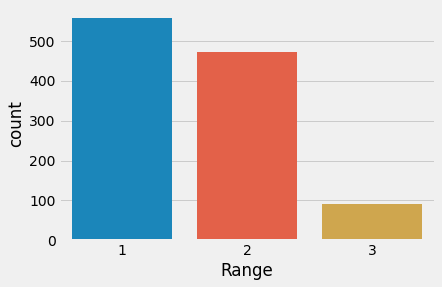

In [ ]:
train_data_T=train_data['Target']
target=[]
for i in range(len(train_data_T)):
    if train_data_T.iloc[i] < 10:
        target.append(1)
    elif train_data_T.iloc[i] < 15:
        target.append(2)
    else:
        target.append(3)
        
train_data["Range"] = target

sns.countplot(x = train_data["Range"])

간단하게 copy over sampling을 진행하였다. 이는 간단하게 기존에 존재하는 소수의 클래스를 단순 복제해서 가중치만을 늘려주는 기법이다. 이로써 oversampling을 하기 전보다는 균일한 데이터를 바탕으로 학습을 하여 예측 성능이 더 나아질 것 같았다.

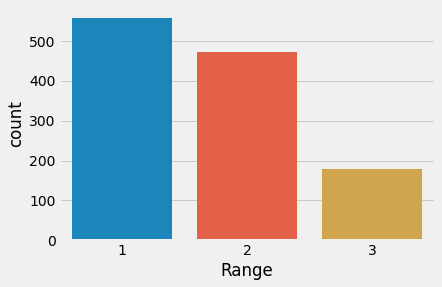

In [ ]:
train_data_3 = train_data[train_data['Range'] == 3]
train_data = train_data.append(train_data_3)
sns.countplot(x = train_data["Range"]) 

## **데이터 분할**

데이터셋 X,Y로 나누어준다.

In [ ]:
data_test = pd.get_dummies(test_data)

train_data = pd.get_dummies(train_data)

train_data_X = train_data.drop(columns = ['Target'], axis = 1)

train_data_y = train_data['Target']


In [ ]:
def NMAE(true, pred):
    score = np.mean(np.abs(true - pred) / true)
    return score

## **모델 학습**

catboost와 ngboost는 코랩에서 지원하지 않기에 직접 설치하였다.

In [ ]:
!pip install catboost
!pip install --upgrade git+https://github.com/stanfordmlgroup/ngboost.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/stanfordmlgroup/ngboost.git to /tmp/pip-req-build-3ntqcvqv
  Running command git clone -q https://github.com/stanfordmlgroup/ngboost.git /tmp/pip-req-build-3ntqcvqv
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.utils import shuffle
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from ngboost import NGBRegressor

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True) #총 15번의 fold 진행
n = 0 #x번째 fold인지 기록

fold_target_pred = []

for train_index, valid_index in skf.split(train_data_X, train_data_X['Range']):
    n += 1
    
    val_pred_name = [] #validation pred model 이름 저장
    val_pred = []      #validation set pred 결과 저장
    target_pred = []   #test set pred 결과 저장
    
    train_X = np.array(train_data_X.drop("Range", axis = 1)) #분배된 학습을 위해 만들어둔 Range feature 제거
    train_Y = np.array(train_data_y)
    
    X_train, X_valid = train_X[train_index], train_X[valid_index]
    y_train, y_valid = train_Y[train_index], train_Y[valid_index]
    
    X_test = np.array(data_test.drop("Target", axis = 1))

    ### Create Model ###
    
    ###모델을 생성하고 집어넣으면 됩니다.
    
    ### MLPRegressor ###
    model_1 = MLPRegressor(random_state = 42, activation = 'tanh')
    model_1.fit(X_train, y_train) # 모델 학습
    
    val_pred_name.append("MLPRegressor")      # 모델 이름 저장
    val_pred.append(model_1.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model_1.predict(X_test)) # test set pred 결과 저장
    
    # ### NGBRegressor ###
    model_2 = NGBRegressor(random_state = 42, verbose = 0)
    model_2.fit(X_train, y_train)
    
    val_pred_name.append("NGBRegressor")      # 모델 이름 저장
    val_pred.append(model_2.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model_2.predict(X_test)) # test set pred 결과 저장
    
    ### XGBRegressor ###
    model_3 = XGBRegressor(random_state = 42,)
    model_3.fit(X_train, y_train)
    
    val_pred_name.append("XGBRegressor")      # 모델 이름 저장
    val_pred.append(model_3.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model_3.predict(X_test)) # test set pred 결과 저장
    
    # ### CatBoostRegressor ###
    model_4 = CatBoostRegressor(iterations = 1000, random_state = 42)
    model_4.fit(X_train, y_train)
    
    val_pred_name.append("CatBoostRegressor")      # 모델 이름 저장
    val_pred.append(model_4.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model_4.predict(X_test)) # test set pred 결과 저장
    
    ### voting ###
    
    ### average validation pred ###
    preds = np.array(val_pred[0])
    for i in range(1, len(val_pred)):
        preds += val_pred[i]
    
    preds = preds/len(val_pred)
    
    ### average target pred ###
    target_preds = np.array(target_pred[0])
    for i in range(1, len(target_pred)):
        target_preds += target_pred[i]
    
    target_preds = target_preds/len(target_pred)
    
    fold_target_pred.append(target_preds) # append final target pred
    
    print("========== fold %d ==========" %(n))
    for i in range(len(val_pred)):
        print("%s model NMAE : %0.4f" %(val_pred_name[i], NMAE(y_valid, val_pred[i].astype(int))))
        
    print("==============================")
    print("Average NMAE %0.4f" %(NMAE(y_valid, preds.astype(int))))
    print("")

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[10:35:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.041498
0:	learn: 3.6625983	total: 53.2ms	remaining: 53.2s
1:	learn: 3.6078384	total: 63.3ms	remaining: 31.6s
2:	learn: 3.5543175	total: 70.2ms	remaining: 23.3s
3:	learn: 3.5016505	total: 72.3ms	remaining: 18s
4:	learn: 3.4521884	total: 78.3ms	remaining: 15.6s
5:	learn: 3.4008170	total: 80.2ms	remaining: 13.3s
6:	learn: 3.3610584	total: 82.2ms	remaining: 11.7s
7:	learn: 3.3194349	total: 88.8ms	remaining: 11s
8:	learn: 3.2794477	total: 91.1ms	remaining: 10s
9:	learn: 3.2430261	total: 97.2ms	remaining: 9.62s
10:	learn: 3.2084804	total: 99ms	remaining: 8.9s
11:	learn: 3.1735464	total: 105ms	remaining: 8.67s
12:	learn: 3.1375051	total: 107ms	remaining: 8.14s
13:	learn: 3.1036647	total: 109ms	remaining: 7.71s
14:	learn: 3.0787045	total: 112ms	remaining: 7.36s
15:	learn: 3.0567159	total: 115ms	remaining: 7.07s
16:	learn: 3.0259570	total: 123ms	r

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[10:35:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.041498
0:	learn: 3.6312139	total: 2.46ms	remaining: 2.45s
1:	learn: 3.5741682	total: 4.77ms	remaining: 2.38s
2:	learn: 3.5264371	total: 7.15ms	remaining: 2.38s
3:	learn: 3.4823232	total: 9.49ms	remaining: 2.36s
4:	learn: 3.4352199	total: 11.7ms	remaining: 2.32s
5:	learn: 3.3888518	total: 13.8ms	remaining: 2.29s
6:	learn: 3.3503225	total: 16ms	remaining: 2.27s
7:	learn: 3.3105072	total: 18.2ms	remaining: 2.26s
8:	learn: 3.2708745	total: 20.5ms	remaining: 2.25s
9:	learn: 3.2359206	total: 22.7ms	remaining: 2.25s
10:	learn: 3.2034192	total: 24.8ms	remaining: 2.23s
11:	learn: 3.1702177	total: 27ms	remaining: 2.22s
12:	learn: 3.1376084	total: 29.1ms	remaining: 2.21s
13:	learn: 3.1068979	total: 31.3ms	remaining: 2.21s
14:	learn: 3.0795162	total: 33.5ms	remaining: 2.2s
15:	learn: 3.0536175	total: 35.8ms	remaining: 2.2s
16:	learn: 3.0252878	total:

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[10:36:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.041498
0:	learn: 3.6500719	total: 2.42ms	remaining: 2.41s
1:	learn: 3.5965175	total: 5.01ms	remaining: 2.5s
2:	learn: 3.5470191	total: 7.67ms	remaining: 2.55s
3:	learn: 3.5013855	total: 9.96ms	remaining: 2.48s
4:	learn: 3.4522295	total: 12.1ms	remaining: 2.42s
5:	learn: 3.4057582	total: 14.4ms	remaining: 2.38s
6:	learn: 3.3640725	total: 16.5ms	remaining: 2.34s
7:	learn: 3.3228552	total: 18.5ms	remaining: 2.3s
8:	learn: 3.2832990	total: 20.6ms	remaining: 2.27s
9:	learn: 3.2485969	total: 22.5ms	remaining: 2.23s
10:	learn: 3.2204089	total: 24.5ms	remaining: 2.21s
11:	learn: 3.1847715	total: 26.3ms	remaining: 2.17s
12:	learn: 3.1580981	total: 28.2ms	remaining: 2.14s
13:	learn: 3.1258557	total: 30.2ms	remaining: 2.13s
14:	learn: 3.1019467	total: 32ms	remaining: 2.1s
15:	learn: 3.0722037	total: 34.1ms	remaining: 2.1s
16:	learn: 3.0425097	total:

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[10:36:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.041498
0:	learn: 3.6575200	total: 2.1ms	remaining: 2.09s
1:	learn: 3.6030113	total: 4.43ms	remaining: 2.21s
2:	learn: 3.5521636	total: 6.82ms	remaining: 2.27s
3:	learn: 3.5093626	total: 9.18ms	remaining: 2.28s
4:	learn: 3.4636111	total: 12ms	remaining: 2.38s
5:	learn: 3.4161463	total: 14.2ms	remaining: 2.35s
6:	learn: 3.3723645	total: 16.4ms	remaining: 2.32s
7:	learn: 3.3282717	total: 18.7ms	remaining: 2.32s
8:	learn: 3.2963991	total: 20ms	remaining: 2.2s
9:	learn: 3.2592482	total: 22.3ms	remaining: 2.2s
10:	learn: 3.2221851	total: 24.4ms	remaining: 2.2s
11:	learn: 3.1870915	total: 26.8ms	remaining: 2.2s
12:	learn: 3.1515554	total: 28.6ms	remaining: 2.17s
13:	learn: 3.1166682	total: 30.9ms	remaining: 2.17s
14:	learn: 3.0881206	total: 33.1ms	remaining: 2.17s
15:	learn: 3.0582542	total: 35.4ms	remaining: 2.17s
16:	learn: 3.0316191	total: 37

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[10:36:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.041498
0:	learn: 3.6393816	total: 1.91ms	remaining: 1.91s
1:	learn: 3.5851205	total: 3.73ms	remaining: 1.86s
2:	learn: 3.5324455	total: 5.84ms	remaining: 1.94s
3:	learn: 3.4871226	total: 8.14ms	remaining: 2.03s
4:	learn: 3.4401911	total: 10.3ms	remaining: 2.05s
5:	learn: 3.3957382	total: 12.9ms	remaining: 2.13s
6:	learn: 3.3524494	total: 15ms	remaining: 2.12s
7:	learn: 3.3104188	total: 17.2ms	remaining: 2.13s
8:	learn: 3.2671356	total: 19.3ms	remaining: 2.12s
9:	learn: 3.2341938	total: 21.4ms	remaining: 2.12s
10:	learn: 3.2003081	total: 23.3ms	remaining: 2.1s
11:	learn: 3.1676917	total: 25.7ms	remaining: 2.11s
12:	learn: 3.1415113	total: 28.2ms	remaining: 2.14s
13:	learn: 3.1101019	total: 30.6ms	remaining: 2.15s
14:	learn: 3.0814103	total: 32.8ms	remaining: 2.15s
15:	learn: 3.0510611	total: 35.1ms	remaining: 2.16s
16:	learn: 3.0286270	tot

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[10:36:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.041498
0:	learn: 3.6233287	total: 2.09ms	remaining: 2.08s
1:	learn: 3.5691150	total: 4.12ms	remaining: 2.05s
2:	learn: 3.5173973	total: 6.13ms	remaining: 2.04s
3:	learn: 3.4754240	total: 8.07ms	remaining: 2.01s
4:	learn: 3.4262649	total: 9.92ms	remaining: 1.97s
5:	learn: 3.3784199	total: 11.8ms	remaining: 1.95s
6:	learn: 3.3389579	total: 13.7ms	remaining: 1.94s
7:	learn: 3.2975435	total: 15.7ms	remaining: 1.94s
8:	learn: 3.2628086	total: 17.9ms	remaining: 1.98s
9:	learn: 3.2271094	total: 20.3ms	remaining: 2.01s
10:	learn: 3.1983121	total: 23.6ms	remaining: 2.12s
11:	learn: 3.1651575	total: 25.8ms	remaining: 2.13s
12:	learn: 3.1328905	total: 28.1ms	remaining: 2.13s
13:	learn: 3.1020380	total: 30.3ms	remaining: 2.13s
14:	learn: 3.0696203	total: 32.6ms	remaining: 2.14s
15:	learn: 3.0406911	total: 35.3ms	remaining: 2.17s
16:	learn: 3.0120571	

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[10:36:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.041498
0:	learn: 3.6265210	total: 2.15ms	remaining: 2.15s
1:	learn: 3.5724001	total: 4.62ms	remaining: 2.31s
2:	learn: 3.5242587	total: 7.13ms	remaining: 2.37s
3:	learn: 3.4790167	total: 9.46ms	remaining: 2.36s
4:	learn: 3.4288117	total: 11.9ms	remaining: 2.36s
5:	learn: 3.3802050	total: 14.5ms	remaining: 2.4s
6:	learn: 3.3355648	total: 16.7ms	remaining: 2.37s
7:	learn: 3.2964823	total: 19.2ms	remaining: 2.38s
8:	learn: 3.2589010	total: 21.8ms	remaining: 2.4s
9:	learn: 3.2259842	total: 24.4ms	remaining: 2.42s
10:	learn: 3.1928971	total: 26.7ms	remaining: 2.4s
11:	learn: 3.1569754	total: 29.7ms	remaining: 2.45s
12:	learn: 3.1261864	total: 32.1ms	remaining: 2.44s
13:	learn: 3.0969714	total: 34.3ms	remaining: 2.42s
14:	learn: 3.0656792	total: 36.5ms	remaining: 2.4s
15:	learn: 3.0403140	total: 38.8ms	remaining: 2.38s
16:	learn: 3.0111741	tota

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[10:37:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.041498
0:	learn: 3.6398006	total: 3.49ms	remaining: 3.49s
1:	learn: 3.5861845	total: 7.79ms	remaining: 3.88s
2:	learn: 3.5353346	total: 10.1ms	remaining: 3.35s
3:	learn: 3.4936430	total: 12.5ms	remaining: 3.12s
4:	learn: 3.4425966	total: 14.8ms	remaining: 2.95s
5:	learn: 3.3994454	total: 17.1ms	remaining: 2.83s
6:	learn: 3.3604712	total: 19.2ms	remaining: 2.73s
7:	learn: 3.3181205	total: 21.5ms	remaining: 2.67s
8:	learn: 3.2759691	total: 23.7ms	remaining: 2.61s
9:	learn: 3.2406413	total: 25.9ms	remaining: 2.56s
10:	learn: 3.2065644	total: 27.8ms	remaining: 2.5s
11:	learn: 3.1649769	total: 30ms	remaining: 2.47s
12:	learn: 3.1325660	total: 32.1ms	remaining: 2.44s
13:	learn: 3.1022934	total: 34.1ms	remaining: 2.4s
14:	learn: 3.0788325	total: 36.1ms	remaining: 2.37s
15:	learn: 3.0544131	total: 38ms	remaining: 2.34s
16:	learn: 3.0290529	total:

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[10:37:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.041498
0:	learn: 3.6292828	total: 2.08ms	remaining: 2.07s
1:	learn: 3.5722838	total: 4.08ms	remaining: 2.04s
2:	learn: 3.5213920	total: 5.89ms	remaining: 1.96s
3:	learn: 3.4789730	total: 8.18ms	remaining: 2.04s
4:	learn: 3.4303768	total: 9.99ms	remaining: 1.99s
5:	learn: 3.3819440	total: 11.8ms	remaining: 1.95s
6:	learn: 3.3406710	total: 13.9ms	remaining: 1.97s
7:	learn: 3.2979544	total: 15.9ms	remaining: 1.97s
8:	learn: 3.2575078	total: 17.8ms	remaining: 1.96s
9:	learn: 3.2244140	total: 19.9ms	remaining: 1.97s
10:	learn: 3.1908928	total: 21.9ms	remaining: 1.97s
11:	learn: 3.1571465	total: 24.3ms	remaining: 2s
12:	learn: 3.1285408	total: 25.9ms	remaining: 1.97s
13:	learn: 3.0980032	total: 27.8ms	remaining: 1.96s
14:	learn: 3.0733754	total: 29.6ms	remaining: 1.95s
15:	learn: 3.0455477	total: 31.6ms	remaining: 1.95s
16:	learn: 3.0170232	tot

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[10:37:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.041498
0:	learn: 3.6520130	total: 1.88ms	remaining: 1.88s
1:	learn: 3.5984375	total: 3.95ms	remaining: 1.97s
2:	learn: 3.5435105	total: 6.05ms	remaining: 2.01s
3:	learn: 3.4976764	total: 8.01ms	remaining: 1.99s
4:	learn: 3.4462631	total: 10.5ms	remaining: 2.1s
5:	learn: 3.3981175	total: 13.8ms	remaining: 2.29s
6:	learn: 3.3551975	total: 15.5ms	remaining: 2.2s
7:	learn: 3.3153838	total: 17.4ms	remaining: 2.16s
8:	learn: 3.2736653	total: 19.3ms	remaining: 2.13s
9:	learn: 3.2390126	total: 21.4ms	remaining: 2.12s
10:	learn: 3.2077777	total: 23.4ms	remaining: 2.1s
11:	learn: 3.1684477	total: 26.6ms	remaining: 2.19s
12:	learn: 3.1391923	total: 30.5ms	remaining: 2.31s
13:	learn: 3.1101874	total: 33.5ms	remaining: 2.36s
14:	learn: 3.0820600	total: 37.9ms	remaining: 2.49s
15:	learn: 3.0573071	total: 42ms	remaining: 2.58s
16:	learn: 3.0309105	total